In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt 
import sklearn
import numpy as np 
import torch 
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import time
import random

The uniform approximation theorem states that any continuous function on a compact set can be approximated by the a neural network that is deep enough and wide enough. Then what is the point of constructing GRU or LSTM? The answer is that such structures can better capture the features of the sequnence in a more efficient manner. They are good at doing the following jobs:
1. Balancing the weight between items back in the history and the more recent ones. 
2. Resent the state when a sudden jump/break takes place. 
3. Ignore part of the sequence when their impact is minimum compared to others. 

We briefly explain the structure of both GRU and LSTM. GRU can be treated as a simplified version of LSTM. 
The materials are standard, and we mostly use the resutls from (div-in)

We lay out the notatations:
1. $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ is the current state. (number of examples: $n$, number of inputs: $d$)
2. $\mathbf{H}_{t} \in \mathbb{R}^{n \times h}$ is the hidden state of current time step.
3. $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ is the current reset gate.
4. $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ is the update gate

Mathematically,
$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$
Notice that both the reset gate an the update gate are approximated by passing the linear combination of the current state $\mathbf{X}_t$ and the hidden state $\mathbf{H}_{t-1}$. 

where $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ and
$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ are weight
parameters and $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ are
biases.

Now, given the hidden state and the update gate gate, one needs to find a recurrent relationship to update the hidden state from $\mathbf{H}_{t-1}$ to $\mathbf{H}_{t}$, and this is done by the following: 
$$
\begin{align}
\mathbf{H}_t &= \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t. \tag{3} \label{eq3}\\
\tilde{\mathbf{H}}_t &= \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h) \tag{4} \label{eq4}
\end{align}
$$

The purpose of \eqref{eq4} is that one can decide how much of the past information encoded in $\mathbf{H}_{t-1}$ can be forgotten, and a new `candidate` hidden state $\tilde{\mathbf{H}}_{t}$ can be proposed.  Then $\mathbf{H}_{t-1}$ is updated by keeping $\mathbf{Z}_t$ portion of the past hidden state and ($1-\mathbf{Z}_t$) portion of the current candidate state.btain 

Finally, to obtain an output, the following linear transformation is done on the hidden state $\mathbf{H}_t$.
$$\mathbf{Y}_t=\mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q $$
where $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ and $\mathbf{b}_q \in \mathbb{R}^q$.

## Long Short-term Memory (LSTM)

Similar to the GRU, the LSTM has a few units that are in charge of different functions. In particular, it has the following: 
1. $\mathbf{I}_t \in \mathbb{R}^{n \times h}$ is the input gate.
2.$\mathbf{F}_t \in \mathbb{R}^{n \times h}$ is the forget gate. 
3.$\mathbf{O}_t \in \mathbb{R}^{n \times h}$ is the output gate. 
4.$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ is the state vector. 
5.$\mathbf{H}_{t} \in \mathbb{R}^{n \times h}$ is the hidden state vector at time t.

Of course, each of them will consist of an activation function and some linear combination of hiddend state and the current state. 

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$






There is a candidate memory cell  $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$:
$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$
In GRU $\mathbf{Z}_t$ is designed for updating the memory, the LSTM is more elaborate on this part ($\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ ):
$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$
That is, some part of the information is to be forgotten by applying $\mathbf{F}_t$ while more recent ones are added through $\mathbf{I}_t$, in the extreme case. If $\mathbf{F}_t=1$, then all the history will be retained. 

With that, the hidden state will finally be updated: 
$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

Finally, to obtain an output, the following linear transformation is done on the hidden state $\mathbf{H}_t$.
$$\mathbf{Y}_t=\mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q \tag{4}\label{eq4}$$
where $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ and $\mathbf{b}_q \in \mathbb{R}^q$.

## As an example, we do a Bitcoin price prediction

In [5]:
import glob
import pandas as pd
##https://romanorac.github.io/

In [6]:
files = sorted(glob.glob('data/*.csv.gz')) #https://public.bitmex.com/?prefix=data/trade/

In [7]:
df=pd.concat(map(pd.read_csv,files))

In [8]:
df.symbol.unique()

array(['ADAU19', 'BCHU19', 'EOSU19', 'ETHU19', 'ETHUSD', 'LTCU19',
       'TRXU19', 'XBT7D_D95', 'XBT7D_U105', 'XBTU19', 'XBTUSD', 'XBTZ19',
       'XRPU19', 'ADAZ19', 'BCHZ19', 'EOSZ19', 'ETHZ19', 'LTCZ19',
       'TRXZ19', 'XBTH20', 'XRPZ19'], dtype=object)

In [9]:
## Find only the ticker 'XBTUSD'
df=df[df.symbol=='ETHUSD']

In [10]:
df.symbol.unique()

array(['ETHUSD'], dtype=object)

In [11]:
df.timestamp.head()

15654    2019-08-01D00:00:04.853891000
15655    2019-08-01D00:00:04.853891000
15656    2019-08-01D00:00:04.853891000
15657    2019-08-01D00:00:04.853891000
15658    2019-08-01D00:00:04.853891000
Name: timestamp, dtype: object

In [12]:
temp=pd.to_datetime(df.timestamp.str.replace('D', 'T'))

In [13]:
## Now the timestamp has the string format
temp.head() 

15654   2019-08-01 00:00:04.853891
15655   2019-08-01 00:00:04.853891
15656   2019-08-01 00:00:04.853891
15657   2019-08-01 00:00:04.853891
15658   2019-08-01 00:00:04.853891
Name: timestamp, dtype: datetime64[ns]

In [14]:
df.timestamp=temp

In [15]:
df.sort_values('timestamp') ## Sort the time, make sure it is in a correct order

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
15654,2019-08-01 00:00:04.853891,ETHUSD,Buy,2299,218.65,ZeroPlusTick,df8dd289-8760-2cbb-273b-cad2b3406f7e,50267635,23.191770,5070.8800
15669,2019-08-01 00:00:04.853891,ETHUSD,Buy,1592,218.65,ZeroPlusTick,815c838f-9744-b0c9-98d2-240a56728ada,34809080,16.059720,3511.4580
15668,2019-08-01 00:00:04.853891,ETHUSD,Buy,84,218.65,ZeroPlusTick,6527b40c-24fe-92a1-114e-0c6c1d51106c,1836660,0.847372,185.2779
15666,2019-08-01 00:00:04.853891,ETHUSD,Buy,104,218.65,ZeroPlusTick,8086cbd8-9211-c134-918e-74ad23385682,2273960,1.049127,229.3917
15665,2019-08-01 00:00:04.853891,ETHUSD,Buy,320,218.65,ZeroPlusTick,ef82bcb9-246d-0531-3617-d353da22322d,6996800,3.228084,705.8206
...,...,...,...,...,...,...,...,...,...,...
174437,2019-09-17 23:59:51.986160,ETHUSD,Sell,1000,208.05,MinusTick,8c84ed31-7cf2-a12e-27d3-33ccc9e8388b,20805000,10.185370,2119.0670
174438,2019-09-17 23:59:57.707769,ETHUSD,Buy,3021,208.10,PlusTick,5a5956f7-5db0-9e30-9aa3-545c906ce139,62867010,30.770010,6403.2400
174439,2019-09-17 23:59:57.908414,ETHUSD,Sell,98,208.05,MinusTick,4902289c-b2ef-22db-4094-0859d515e57f,2038890,0.998167,207.6686
174440,2019-09-17 23:59:59.552126,ETHUSD,Sell,200,208.05,ZeroMinusTick,2bc81d78-9866-7b9a-7ad6-34d04d7e78fc,4161000,2.037075,423.8134


In [16]:
## setting timestamp as the index
df.set_index('timestamp',inplace=True)

Since the trading frequence is very high, we define a `bucketing` or `grouping` procedure, and set the bucketsize to be one mininute.

In [17]:
## Grouper on the index, the timestamp
df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: pd.np.sum(row.price * row.foreignNotional) / pd.np.sum(row.foreignNotional)
)
df_vwap.shape

C:\Users\huisu\anaconda3\envs\gputest2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\huisu\anaconda3\envs\gputest2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


(69120,)

In [18]:
## See the total amount of size deduction
df.shape, df_vwap.shape

((3200700, 9), (69120,))

In [19]:
## We are more interested in the only the price
df_vwap.head()

timestamp
2019-08-01 00:00:00    219.130670
2019-08-01 00:01:00    219.052830
2019-08-01 00:02:00    218.879993
2019-08-01 00:03:00    218.657818
2019-08-01 00:04:00    218.744374
Freq: T, dtype: float64

Text(0.5, 1.0, '')

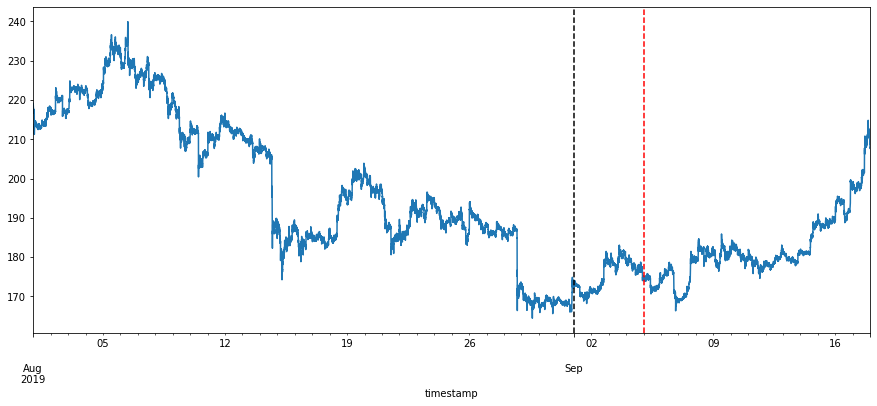

In [20]:
ax=df_vwap.plot(figsize=(15, 6))
ax.axvline("2019-09-01", linestyle="--", c="black") # Find the two plots that are of interest
ax.axvline("2019-09-05", linestyle="--", c="red")
plt.title('')

This is a sequential problem, hence data split should takes into consideration the time order. 

In [21]:
df_train=df_vwap[df_vwap.index< "2019-09-01"].to_frame(name="vwap")
df_train.shape

(44640, 1)

In [22]:
# One out of time test  period
df_val = df_vwap[(df_vwap.index >= "2019-09-01") & (df_vwap.index < "2019-09-05")].to_frame(name="vwap")
df_val.shape

df_test = df_vwap[df_vwap.index >= "2019-09-05"].to_frame(name='vwap')
df_test.shape

(18720, 1)

In [32]:
df_train=df_train.dropna()
df_val=df_val.dropna()
df_test=df_test.dropna()

In [31]:
df_val.isna().sum()

vwap    40
dtype: int64

In [33]:
df_train.isna().sum(),df_val.isna().sum()

(vwap    0
 dtype: int64,
 vwap    0
 dtype: int64)

In [34]:
# Normalizing the data to make sure then are on the same scale
from sklearn.preprocessing import StandardScaler

scaler =StandardScaler()

## Transform the input data
train_arr = scaler.fit_transform(df_train)

## Use the fitted data to transform
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

In [40]:
np.isnan(train_arr).sum(), np.isnan(val_arr).sum(), np.isnan(test_arr).sum()

(0, 0, 0)

We are interested in predicting the next minute's stock price using the past 100 stock prices. 

In [41]:
def transform_data(price_vec, seq_len):
    base=[]
    target=[]
    for i in range(len(price_vec)-seq_len):
        xi=price_vec[i:i+seq_len]
        yi=price_vec[i+1:i + seq_len + 1]
        
        base.append(xi)
        target.append(yi)
        
    base=np.array(base).reshape(-1, seq_len)
    target=np.array(target).reshape(-1, seq_len)
    
    base=Variable(torch.from_numpy(base).float())
    target=Variable(torch.from_numpy(target).float())
    return base, target

In [42]:
seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len) # y_train is simply the 1-next 100 values
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

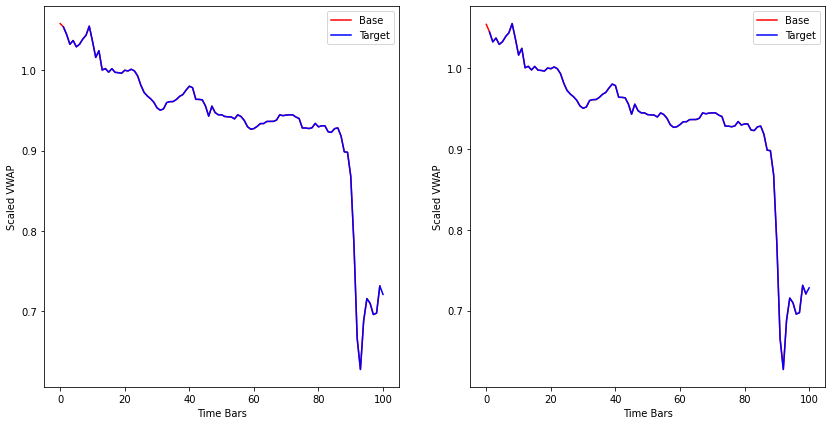

In [43]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,7))
for i in range(2):
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Base")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

## Constucting the model --LSTM

In [48]:
class Config(object):
    input_size=1
    output_size=1
    hidden_size=16

In [49]:
class Model(nn.Module):
    def __init__(self,cfg):
        super(Model,self).__init__()
        self.input_size=cfg.input_size
        self.output_size=cfg.output_size
        self.hidden_size=cfg.hidden_size
        self.lstm=nn.LSTMCell(self.input_size,self.hidden_size)
        self.linear=nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self,x_in, future=0,y=None):
        outputs=[]
        # Initialization 
        batch_size=x_in.shape[0]
        h_t=torch.zeros(batch_size,self.hidden_size, dtype=torch.float32)
        c_t=torch.zeros(batch_size,self.hidden_size, dtype=torch.float32)
        
        for i, x_ini in enumerate(x_in.chunk(x_in.size(1),dim=1)):
            h_t, c_t = self.lstm(x_ini,(h_t,c_t) )
            output=self.linear(h_t) ## output is a linear transform of hidden according to equation 4
            outputs.append(output)
        
        ###  future is the number of look-ahead steps
        for i in range(future): 
            if y is not None and random.random()>0.5:
                output=y[:,[i]]
            h_t,c_t=self.lstm(output,(h_t,c_t))
            output=self.linear(h_t)
            outputs+=[output] 
            
        outputs=torch.stack(outputs,1).squeeze(2)
        return outputs

In [50]:
def generate_batch_data(x,y,batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch 

In [51]:
cfg=Config()
loss_fn=nn.MSELoss()
model=Model(cfg)
optimizer=optim.Adam(model.parameters(),lr=1e-3)
scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [52]:
batch_size=100
nepochs=14
seq_len=x_train.shape[1]
val_losses=[]
train_losses=[]

for epoch in range(nepochs):
    train_loss=0
    start_time=time.time()
    
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred=model(x_batch)
        optimizer.zero_grad()
        loss=loss_fn(y_pred,y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        
    scheduler.step()
    train_loss=train_loss/batch
    
    train_losses.append(train_loss)
    
    ## The validation process
    with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            val_losses.append(val_loss)
            
    elapsed = time.time() - start_time

    print("Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, val_losses[-1], elapsed)
            )

Epoch 1 Train loss: 0.39. Validation loss: 0.27. Elapsed time: 12.23s.
Epoch 2 Train loss: 0.09. Validation loss: 0.19. Elapsed time: 10.88s.
Epoch 3 Train loss: 0.06. Validation loss: 0.12. Elapsed time: 10.63s.
Epoch 4 Train loss: 0.03. Validation loss: 0.05. Elapsed time: 10.60s.
Epoch 5 Train loss: 0.02. Validation loss: 0.03. Elapsed time: 10.58s.
Epoch 6 Train loss: 0.04. Validation loss: 0.01. Elapsed time: 10.54s.
Epoch 7 Train loss: 0.02. Validation loss: 0.01. Elapsed time: 10.54s.
Epoch 8 Train loss: 0.01. Validation loss: 0.01. Elapsed time: 10.53s.
Epoch 9 Train loss: 0.01. Validation loss: 0.01. Elapsed time: 10.52s.
Epoch 10 Train loss: 0.01. Validation loss: 0.01. Elapsed time: 10.50s.
Epoch 11 Train loss: 0.01. Validation loss: 0.01. Elapsed time: 10.50s.
Epoch 12 Train loss: 0.01. Validation loss: 0.01. Elapsed time: 10.50s.
Epoch 13 Train loss: 0.01. Validation loss: 0.01. Elapsed time: 10.51s.
Epoch 14 Train loss: 0.01. Validation loss: 0.01. Elapsed time: 10.51s.


Text(0.5, 0, 'Iterations')

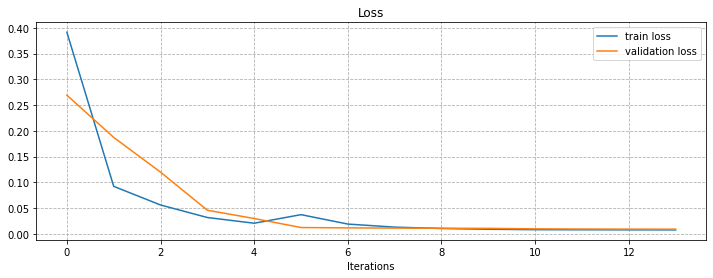

In [75]:
plt.figure(figsize=(12,4))
plt.plot(train_losses)
plt.plot(val_losses)
plt.grid(linestyle='--')
plt.legend(['train loss', 'validation loss'])
plt.title('Loss')
plt.xlabel('Iterations')

### Testing the OOT (out of time) performance

In [55]:
with torch.no_grad():
    test_loss = 0
    actual, predicted = [], []
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch, future=0) ## Future is 4. 
        y_pred = (
            y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
        )
        loss = loss_fn(y_pred, y_batch)
        test_loss += loss.item()
        actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
        predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
    test_loss /= batch

In [56]:
df_eval=pd.DataFrame({"actual":actual,"predicted":predicted})

In [57]:
## Inverse transform the predicted value to the oringal set 
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col].values.reshape(-1,1))
    return df

In [58]:
df_eval_scale=inverse_transform(scaler,df_eval,df_eval.columns)

In [59]:
col_name=df_eval_scale.columns

In [60]:
df_eval_scale['Pred-Actual-Diff']=np.abs(df_eval_scale['actual']-df_eval_scale['predicted'])
df_eval_scale['percent_error']=np.abs(df_eval_scale['Pred-Actual-Diff']/df_eval_scale['actual'])

Text(0.5, 1.0, 'Next day price prediction')

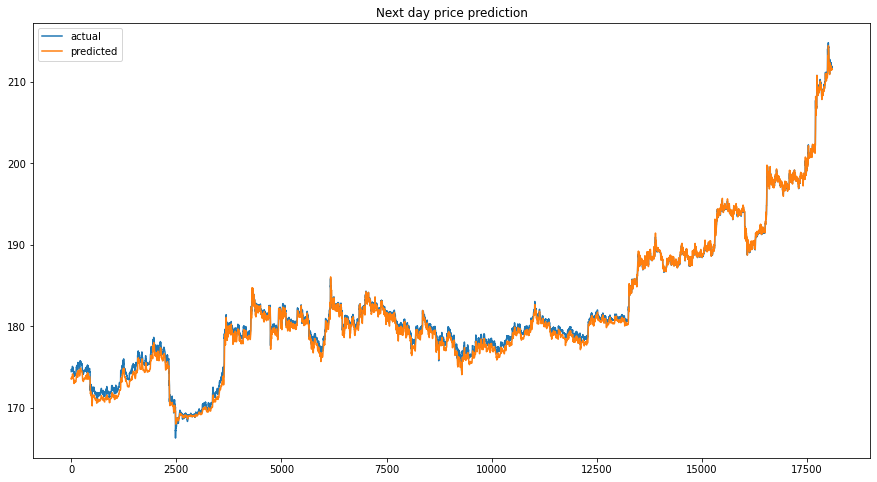

In [61]:
df_eval_scale[['actual','predicted']].plot(figsize=(15,8))
plt.title('Next day price prediction')

Text(0.5, 1.0, 'Prediction percentage error')

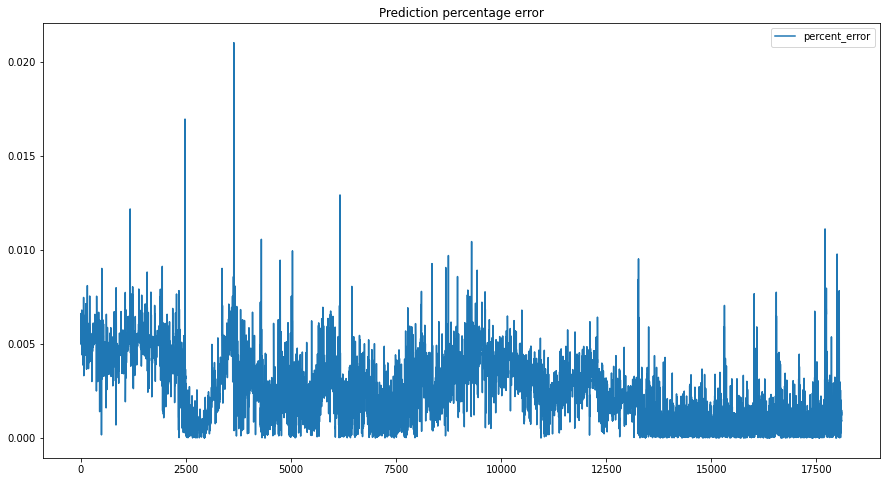

In [62]:
df_eval_scale[['percent_error']].plot(figsize=(15,8))
plt.title('Prediction percentage error')

### Quality of the prediction decays as one looks more ahead

In [63]:
with torch.no_grad():
    test_loss = 0
    actual, predicted = [], []
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch, future=4) ## Future is 4. 
        y_pred = (
            y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
        )
        loss = loss_fn(y_pred, y_batch)
        test_loss += loss.item()
        actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
        predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
    test_loss /= batch

In [64]:
df_eval=pd.DataFrame({"actual":actual,"predicted":predicted})

In [65]:
df_eval_scale=inverse_transform(scaler,df_eval,df_eval.columns)

In [66]:
col_name=df_eval_scale.columns
df_eval_scale['Pred-Actual-Diff']=np.abs(df_eval_scale['actual']-df_eval_scale['predicted'])
df_eval_scale['percent_error']=np.abs(df_eval_scale['Pred-Actual-Diff']/df_eval_scale['actual'])

Text(0.5, 1.0, 'Four day look ahead')

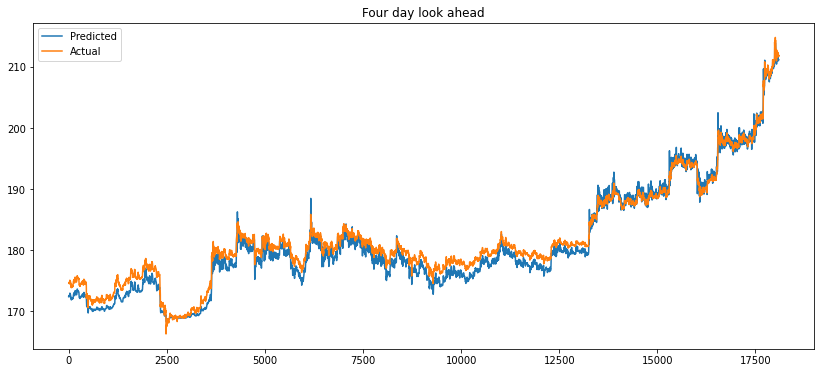

In [67]:
# As one can observe, the five-minute-lookahead results are worse compared to the next day predictions
plt.figure(figsize=(14,6))
plt.plot(df_eval_scale['predicted'][:-4])
plt.plot(df_eval_scale['actual'][4:])
plt.legend(['Predicted','Actual'])
plt.title('Four day look ahead')